In [1]:
import numpy as np
from matplotlib import pyplot as plt
from copy import deepcopy

#### CGL estimation algorithm

In [2]:
# Function for finding the best CGL estimate under connectivity constraints.

# Inputs: S - Kernel data matrix,
#         W - connectivity matrix with entries 0/1
#         alpha - regularisation parameter
#         tol - error tolerance for the optimisation problem (stopping criterion)
#         max_cycle - maximum number of cycles (stopping criterion)

# Outputs: C - estimated inverse of O
#          O - estimated combinatorial graph Laplacian (L)
#          converged - logical variable determining the convergence of the estimator 
#          frob_norm - vector of normalised differences between esimtates of O between cycles: |O(t-1)-O(t)|_F/|O(t-1)|_F 

def estimate_cgl(S, W, lambda_reg, tol, max_cycle):
    
    # number of vertices in the graph
    J = S.shape[1]
    
    # eigenvector corresponding to zero eigenvalue of CGL
    ev = np.ones((J, 1))/np.sqrt(J)
    
    # check if S is combinatorial matrix by the rows sum
    singularity_issue = abs(np.sum(S)) < tol
    
    # for GGL and DDGL K=S+H while for CGL is K=(S+ev)+H, where ev=11/J
    if singularity_issue:
        S = S + 1/J
        
    # regularisation matrix H
    H_alpha = lambda_reg * (2*np.eye(J) - np.ones((J,J)))
        
    K = S + H_alpha
   
    # initialising values (O - inverse of C)
    C = np.diag(np.diag(K))
    O = np.diag(1/np.diag(K))
    
    # best output
    O_best, C_best = O, C
    
    frob_norm = []
    converged = False
    cycle = 0
    
    # repeat until convergence or max number of cycles
    while not converged and cycle < max_cycle:
    
        O_old = deepcopy(O)

        for u in range(J):
            
            ## Partition estimated matrices O, C, K and A for u

            # delete u-th row and u-th column from K matrix
            K_u = np.delete(K, u, 0)
            K_u = np.delete(K_u, u, 1)
            
            # u-th column of K without u-th element (diagonal element)
            k_u = K[:, u]
            k_u = np.delete(k_u, u)
            
            # scalar element 
            k_uu = K[u,u]
        
            # delete u-th row and u-th column from K matrix
            C_u = np.delete(C, u, 0)
            C_u = np.delete(C_u, u, 1)
            
            c_u = C[:, u]
            c_u = np.delete(c_u, u)
            
            c_uu = C[u,u]
            
            a_u = W[:, u]
            a_u = np.delete(a_u, u)
            
            ## Block-coordinate updates
            
            # Calculate inverse Theta_u
            Ou_inverse = C_u - np.outer(c_u, c_u)/c_uu

            ## Solve the quadratic program for beta with Q, p and S
            
            # define Q, p and S (block-descent variables)
            S_indx = (a_u == 1)
            Q = Ou_inverse[:, S_indx][S_indx, :]

            # solve nonnegative quadratic program (block-descent step)
            o_u = O[:, u]
            o_u = np.delete(o_u, u)
            qp_result = - o_u[S_indx]
            
            # solution beta of QP program 0 outside of index set S
            beta = np.zeros(J-1)
            beta[S_indx] = qp_result
            
            # update vector o_u and scalar o_uu using solution beta from above
            o_u = (1/J) - beta
            o_uu = (1/k_uu) + np.matmul(np.matmul((qp_result-1/J).T, Q), qp_result-1/J)
            
            # update the current Theta
            minus_u = [i for i in range(J) if i != u]
            O[u, u] = o_uu
            O[minus_u, u] = o_u
            O[u, minus_u] = o_u
      
            # update vector c_u and scalar c_uu
            c_uu = 1/(o_uu - np.matmul(o_u.T, np.matmul(Ou_inverse, o_u)))
            c_u = np.dot(Ou_inverse, o_u)/c_uu
            
            # update the current Theta inverse (i.e. C)
            C[u, u] = c_uu
            C[u, minus_u] = -c_u
            C[minus_u, u] = -c_u
            
            # use Sherman-Woodbury
            RHS =  Ou_inverse + np.outer(c_u, c_u)/c_uu
            m = C.shape[0]
            r = 0
            for i in range(m):
                if i!=u:
                    c = 0
                    for j in range(m):
                        if j!=u:
                            C[i,j] = RHS[r,c]
                            c += 1
                    r += 1
            
        ## Diagonal updates after each cycle
        
        # row sums
        O1 = np.sum(O, axis=0)

        # row sums not equal to one
        large_diag_idx = np.where(abs(O1 - 1) > np.finfo(float).eps)[0]
            
        # if Theta1-1 != 0 then v = -Theta1+1 and Theta[i,i] = Theta[i,i] + v[i]
        for i in range(len(large_diag_idx)):
                
            idx = large_diag_idx[i]
            shift = - O1[idx] + 1
            O[idx, idx] = O[idx, idx] + shift 
                
            # update diagonal entries in C
            c_d = C[idx, idx]
            C = C - (shift * np.outer(C[:,idx], C[idx,:]))/(1 + shift * c_d)
                
        # update optimal O, C and number of cycles
        O_best, C_best = O, C
        cycle += 1
        
        # calculate Frobenius Norms        
        frob_norm.append(np.linalg.norm(O_old - O, 'fro')/np.linalg.norm(O_old, 'fro'))
        
        
        print('Cycle: {:.2f}  --  |Theta(t-1)-Theta(t)|_F/|Theta(t-1)|_F = {:.8f} \n'.format(cycle, frob_norm[-1]))
        
        if cycle > 5:
            
            # convergence criterion with the tolerance
            if frob_norm[-1] < tol:
                converged = True
                O_best, C_best = O, C
        
    # return Theta = Theta-J and C = C-J
    O = O_best - 1/J
    C = C_best - 1/J
    
    return O, C, converged, frob_norm

#### Construct adjacency, degree and CGL matrix

In [3]:
# adjacency and Laplacian matrices
def laplacian(J, s):
    
    A = np.zeros((J, J))
    
    # adjacency matrix
    for i in range(J-1):
        for j in range(i+1, i+2):
            A[i,j] = s
            A[j,i] = A[i,j]
    A[0,J-1] = s
    A[J-1,0] = s

    # degree matrix
    D = np.diag(np.sum(A, axis = 0))

    # combinatorial graph Laplacian
    L = D - A

    return A, L

# number of vertices/trajectories
J = 100

# strength of interaction
s = 10**(-3)

A, L = laplacian(J, s)

#### Dataset

In [4]:
np.random.seed(1047)

# time step
dt = 0.1

# drift function
def f(x, a):
    return -a*x

# Euler Maruyama scheme
def em_step(x0, N, J, a, L):
    
    # Brownian increments
    dw = np.sqrt(dt) * np.random.randn(N+1, J)
    
    # path of X(t)
    x = np.zeros((N+1, J))
    x[0,:] = x0
    
    for i in range(N):
        # simulate a single path in each case J given L respectively
        x[i+1] = x[i] + f(x[i], a) * dt - np.dot(L, x[i]) * dt + dw[i]
    
    return x

# simulation parameters
N = 10**5
x0 = 0
a = 2

# generate samples
x = em_step(x0, N, J, a, L)

#### Construct data statistic and connectivity matrix

In [5]:
def statistics(x, L, A):

    # data statistic as function of L
    P = np.dot(x, L)
    S = np.dot(P.T, P)

    # connectivity matrix with 0/1
    W = np.zeros((J, J))
    for i in range(J):
        for j in range(J):
            if A[i,j] != 0:
                W[i,j] = 1
    
    return S, W

S, W = statistics(x, L, A)

#### CGL algorithm execution

In [6]:
# simulation parameters
max_cycle = 20
tol = 0.01
lambda_reg = -3

# algorithm execution
O, _, _, frob_norm = estimate_cgl(S, W, lambda_reg, tol, max_cycle)

Cycle: 1.00  --  |Theta(t-1)-Theta(t)|_F/|Theta(t-1)|_F = 1.01392667 

Cycle: 2.00  --  |Theta(t-1)-Theta(t)|_F/|Theta(t-1)|_F = 0.47583095 

Cycle: 3.00  --  |Theta(t-1)-Theta(t)|_F/|Theta(t-1)|_F = 0.39477102 

Cycle: 4.00  --  |Theta(t-1)-Theta(t)|_F/|Theta(t-1)|_F = 0.30983867 

Cycle: 5.00  --  |Theta(t-1)-Theta(t)|_F/|Theta(t-1)|_F = 0.24680702 

Cycle: 6.00  --  |Theta(t-1)-Theta(t)|_F/|Theta(t-1)|_F = 0.20237498 

Cycle: 7.00  --  |Theta(t-1)-Theta(t)|_F/|Theta(t-1)|_F = 0.17045730 

Cycle: 8.00  --  |Theta(t-1)-Theta(t)|_F/|Theta(t-1)|_F = 0.14677870 

Cycle: 9.00  --  |Theta(t-1)-Theta(t)|_F/|Theta(t-1)|_F = 0.12865350 

Cycle: 10.00  --  |Theta(t-1)-Theta(t)|_F/|Theta(t-1)|_F = 0.11439471 

Cycle: 11.00  --  |Theta(t-1)-Theta(t)|_F/|Theta(t-1)|_F = 0.10291429 

Cycle: 12.00  --  |Theta(t-1)-Theta(t)|_F/|Theta(t-1)|_F = 0.09348789 

Cycle: 13.00  --  |Theta(t-1)-Theta(t)|_F/|Theta(t-1)|_F = 0.08561824 

Cycle: 14.00  --  |Theta(t-1)-Theta(t)|_F/|Theta(t-1)|_F = 0.07895420 

C

#### Convergence function's plot

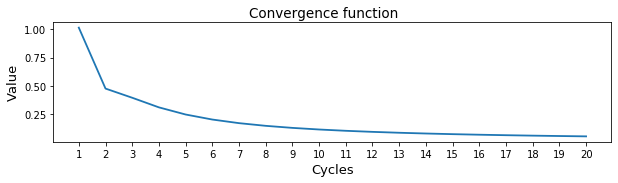

In [9]:
# plot the convergence in both cases
plt.figure(figsize = (10, 2.2))
plt.suptitle('Convergence function', fontsize = 13.5)

# number of cycles in x-axis
cycles = np.arange(1, 21)

plt.xticks(np.arange(1, 21, step = 1))
plt.xlabel('Cycles',fontsize = 13)
plt.ylabel('Value', fontsize = 13.1)
plt.plot(cycles, frob_norm, linewidth = 1.8)

plt.show()

### Histograms of actual and fitted data

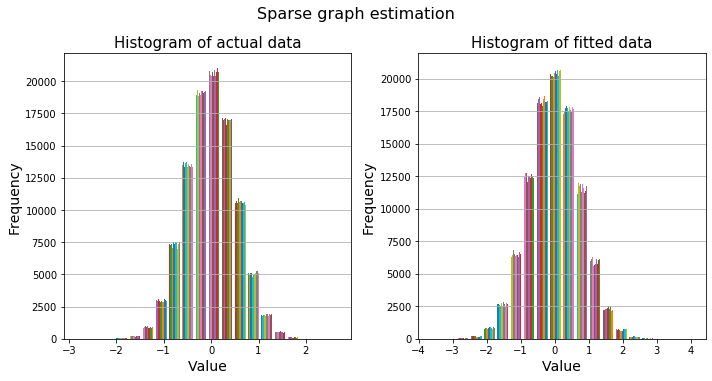

In [9]:
def histograms(actual, fitted):

    fig, (ax1, ax2) = plt.subplots(1, 2, figsize = (10, 5), tight_layout = True)
    
    fig.suptitle('Sparse graph estimation', fontsize = 16, y = 1.05)

    ax1.set_title('Histogram of actual data', fontsize = 15)
    ax1.hist(actual, bins = 20)
    ax1.grid(axis = 'y')
    ax1.set_xlabel('Value', fontsize = 14)
    ax1.set_ylabel('Frequency', fontsize = 14)

    ax2.set_title('Histogram of fitted data', fontsize = 15)
    ax2.hist(fitted, bins = 20)
    ax2.grid(axis = 'y')
    ax2.set_xlabel('Value', fontsize = 14)
    ax2.set_ylabel('Frequency', fontsize = 14)

    plt.show()

# generate samples with the estimated Laplacian
x_est = em_step(x0, N, J, a, O)

# plot the histograms of actual and fitted data
histograms(x, x_est)